Data 

In [8]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print(df)



     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

Node class

In [9]:
class Node():
    def __init__(self,featureIndex = None ,threshold = None,left = None ,right = None,infoGain = None ,value = None ):
        
        self.featureIndex = featureIndex
        self.threshold = threshold 
        self.left = left 
        self.right = right 
        self.infoGain = infoGain

        self.value = value 


Tree class

In [10]:
import numpy as np
import pandas as pd

class DecisionTree():
    def __init__(self, minSamples, maxDepth):
        self.minSamples = minSamples
        self.maxDepth = maxDepth
        self.root = None

    def buildTree(self, dataset, currDepth=0):
        # dataset is expected to be a pandas DataFrame where last column is the target
        X, Y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        numSamples, numCols = dataset.shape
        numFeatures = numCols - 1

       # leaf node 
        if numSamples <= self.minSamples or currDepth >= self.maxDepth:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)

        bestSplit = self.getBestSplit(dataset=dataset, numSamples=numSamples, numFeatures=numFeatures)
        # if no valid split found, make a leaf
        if not bestSplit or bestSplit.get("infoGain", 0) <= 0:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)
        #  build subtrees
        left_subtree = self.buildTree(bestSplit["left"], currDepth + 1)
        right_subtree = self.buildTree(bestSplit["right"], currDepth + 1)
        return Node(featureIndex=bestSplit["featureIndex"], threshold=bestSplit["threshold"], left=left_subtree, right=right_subtree, infoGain=bestSplit["infoGain"])

    def getBestSplit(self, dataset, numSamples, numFeatures):
        max_IG = -float("inf")
        bestSplit = {}

        for featureIndex in range(numFeatures):
            featureSamples = dataset.iloc[:, featureIndex]
            uniqueThresholds = np.sort(np.unique(featureSamples))
            if len(uniqueThresholds) <= 1:
                continue
            possibleThresholds = (uniqueThresholds[:-1] + uniqueThresholds[1:]) / 2.0

            for threshold in possibleThresholds:
                leftDataset, rightDataset = self.split(dataset=dataset, featureIndex=featureIndex, threshold=threshold)
                if len(leftDataset) > 0 and len(rightDataset) > 0:
                    datasetTargets = dataset.iloc[:, -1]
                    leftTargets = leftDataset.iloc[:, -1]
                    rightTargets = rightDataset.iloc[:, -1]
                    datasetEntropy = self.entropy(datasetTargets)
                    leftDatasetEntropy = self.entropy(leftTargets)
                    rightDatasetEntropy = self.entropy(rightTargets)
                    IG = self.informationGain(datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, datasetTargets, leftTargets, rightTargets)
                    if IG > max_IG:
                        max_IG = IG
                        bestSplit["featureIndex"] = featureIndex
                        bestSplit["threshold"] = threshold
                        bestSplit["left"] = leftDataset
                        bestSplit["right"] = rightDataset
                        bestSplit["infoGain"] = IG
        return bestSplit

    def split(self, dataset, featureIndex, threshold):
        mask = np.array(dataset.iloc[:, featureIndex]) <= threshold
        leftDataset, rightDataset = dataset[mask], dataset[~mask]
        return leftDataset, rightDataset

    def entropy(self, dataset):
        datasetEntropy = 0.0
        numberOfExamples = len(dataset)
        classesLabels = np.unique(dataset)
        for cls in classesLabels:
            p = len(dataset[dataset == cls]) / numberOfExamples
            if p > 0:
                datasetEntropy = datasetEntropy - (p * np.log2(p))
        return datasetEntropy

    def informationGain(self, datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, datasetTargets, leftTargets, rightTargets):
        l_weight = len(leftTargets) / len(datasetTargets)
        r_weight = len(rightTargets) / len(datasetTargets)
        IG = datasetEntropy - (l_weight * leftDatasetEntropy + r_weight * rightDatasetEntropy)
        return IG

    def calcLeafValue(self, Y):
        # Y may be a pandas Series; use numpy unique for counts
        classes, counts = np.unique(Y, return_counts=True)
        return classes[np.argmax(counts)]

    def fit(self, X, Y):
        # Ensure dataset is a pandas DataFrame so .iloc works in buildTree
        # X and Y may be numpy arrays; concatenate along columns and wrap in DataFrame
        dataset = pd.DataFrame(np.concatenate((X, Y), axis=1))
        self.root = self.buildTree(dataset)

    def predict(self, X):
        predictions = [self.makePrediction(x, self.root) for x in X]
        return predictions

    def makePrediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature = x[tree.featureIndex]
        if feature <= tree.threshold:
            return self.makePrediction(x, tree.left)
        else:
            return self.makePrediction(x, tree.right)

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print("X_" + str(tree.featureIndex), "<=", tree.threshold, "?", tree.infoGain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)


Train-Test split

In [11]:
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=41)


Fit the model

In [12]:
classifier  = DecisionTree(minSamples=3,maxDepth=15)
classifier.fit(X_train,Y_train)


Print tree

In [13]:
classifier.print_tree()

X_7 <= 0.049229999999999996 ? 0.5516364837002203
 left:X_20 <= 16.83 ? 0.13232456637189233
  left:X_13 <= 48.7 ? 0.04640094813817412
    left:X_21 <= 30.145 ? 0.030968450694226934
        left:1.0
        right:X_26 <= 0.20425 ? 0.1394385767954091
                left:1.0
                right:X_5 <= 0.0678 ? 0.4204484631347318
                                left:0.0
                                right:X_4 <= 0.098485 ? 0.4689955935892812
                                                                left:1.0
                                                                right:0.0
    right:0.0
  right:X_1 <= 19.545 ? 0.5548894409556178
    left:X_28 <= 0.26049999999999995 ? 0.46691718668869925
        left:1.0
        right:0.0
    right:0.0
 right:X_23 <= 874.9 ? 0.2712979618346121
  left:X_21 <= 25.655 ? 0.5409813230754511
    left:X_25 <= 0.31205 ? 0.27752217309880617
        left:1.0
        right:X_11 <= 0.9699 ? 0.9910760598382222
                left:0.0
                ri

Test model

In [14]:
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9210526315789473

In [18]:
# Visualize and export the learned Decision Tree as an image using graphviz
# Requires: `pip install graphviz` and system graphviz installed (e.g. apt install graphviz)
try:
    from graphviz import Digraph
except Exception as e:
    raise ImportError(
        "graphviz Python package is required. Install with: pip install graphviz\n" \
        "Also install system graphviz (on Ubuntu: sudo apt-get install graphviz).\n" \
        f"Error: {e}"
    )
from IPython.display import Image, display


def visualize_and_export(tree, feature_names=None, out_file='decision_tree', out_format='png'):
    """Render a DecisionTree (Node) using graphviz, display inline, and save an image.

    Args:
        tree: root Node instance (from your DecisionTree implementation)
        feature_names: list of feature names (optional)
        out_file: base filename (without extension) to write
        out_format: image format to write (png, pdf, svg, etc.)

    Returns:
        path to the written file
    """
    if tree is None:
        raise ValueError('Tree is None; fit the classifier first')

    dot = Digraph(format=out_format)
    dot.attr('node', fontsize='10', shape='box')

    def node_label(node):
        if node.value is not None:
            return f'Leaf\nvalue={node.value}'
        else:
            fname = feature_names[node.featureIndex] if feature_names is not None and len(feature_names) > node.featureIndex else f'X_{node.featureIndex}'
            # keep labels short and readable
            thr = node.threshold
            ig = node.infoGain if node.infoGain is not None else ''
            return f'{fname} <= {thr}\nIG={ig}'

    def recurse(node):
        nid = str(id(node))
        dot.node(nid, node_label(node))
        if getattr(node, 'left', None) is not None:
            left_id = recurse(node.left)
            dot.edge(nid, left_id, label='yes', fontsize='8')
        if getattr(node, 'right', None) is not None:
            right_id = recurse(node.right)
            dot.edge(nid, right_id, label='no', fontsize='8')
        return nid

    recurse(tree)

    out_path = dot.render(filename=out_file, cleanup=True)
    # Graphviz's render usually returns out_file + '.' + out_format
    print(f'Wrote: {out_path}')

    # display inline if possible
    try:
        display(Image(filename=out_path))
    except Exception:
        print('Could not display image inline; open the file at:', out_path)

    return out_path


# Example usage (uncomment and run after you fit the classifier):
# feature_names = list(df.columns[:-1]) if 'df' in globals() else None
# path = visualize_and_export(classifier.root, feature_names=feature_names, out_file='breast_tree', out_format='png')
# print('Saved tree image to', path)


Wrote: breast_tree.png


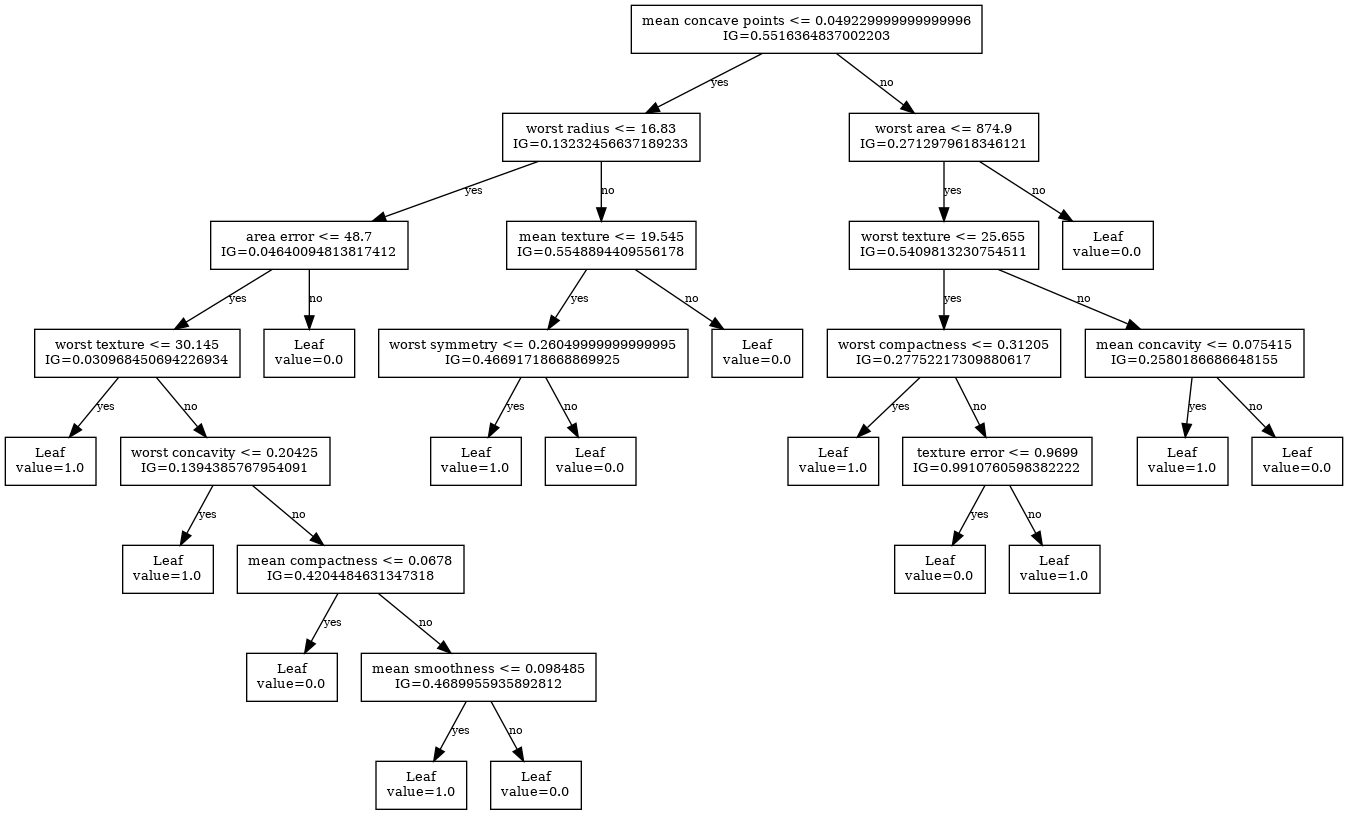

Saved tree to breast_tree.png


In [19]:
# Call the visualization helper to render and save the tree image
feature_names = list(df.columns[:-1]) if 'df' in globals() else None
path = visualize_and_export(classifier.root, feature_names=feature_names, out_file='breast_tree', out_format='png')
print('Saved tree to', path)
